<a href="https://colab.research.google.com/github/HippocampusTeam/DNNT-TensorFlow/blob/graph/DNNT_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [23]:
import csv

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [24]:
%matplotlib inline
plt.style.use('Solarize_Light2')

from matplotlib import rcParams
rcParams['figure.figsize'] = 17, 8

%config InlineBackend.figure_format = 'retina'

In [25]:
# Load data

is_local = True

if not is_local:
    from google.colab import drive
    drive.mount('/content/drive')

# Read data in from file
with open('./banknotes/banknotes.csv' if is_local else '/content/drive/MyDrive/DNNT/data/banknotes.csv') as f:
    reader = csv.reader(f)
    next(reader)

    data = []
    for row in reader:
        data.append({
            "evidence": [float(cell) for cell in row[:4]],
            "label": 1 if row[4] == "0" else 0
        })

# Separate data into training and testing groups
evidence = [row["evidence"] for row in data]
labels = [row["label"] for row in data]
X_training, X_testing, y_training, y_testing = train_test_split(
    evidence, labels, test_size=0.2
)

In [31]:
# Create a neural network
test_model = tf.keras.models.Sequential()
test_model.add(tf.keras.layers.Dense(3, input_shape=(4,), activation="relu"))
test_model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

# Train neural network
test_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

test_model.fit(X_training, y_training, epochs=15)

Epoch 1/15
26/26 [==============================] - 0s 600us/step - loss: 0.7582 - accuracy: 0.7078
Epoch 2/15
26/26 [==============================] - 0s 600us/step - loss: 0.6600 - accuracy: 0.7393
Epoch 3/15
26/26 [==============================] - 0s 520us/step - loss: 0.6225 - accuracy: 0.7437
Epoch 4/15
26/26 [==============================] - 0s 560us/step - loss: 0.5291 - accuracy: 0.7867
Epoch 5/15
26/26 [==============================] - 0s 600us/step - loss: 0.4869 - accuracy: 0.8008
Epoch 6/15
26/26 [==============================] - 0s 640us/step - loss: 0.4403 - accuracy: 0.7928

100%|██████████| 4/4 [00:51<00:00, 12.99s/it]


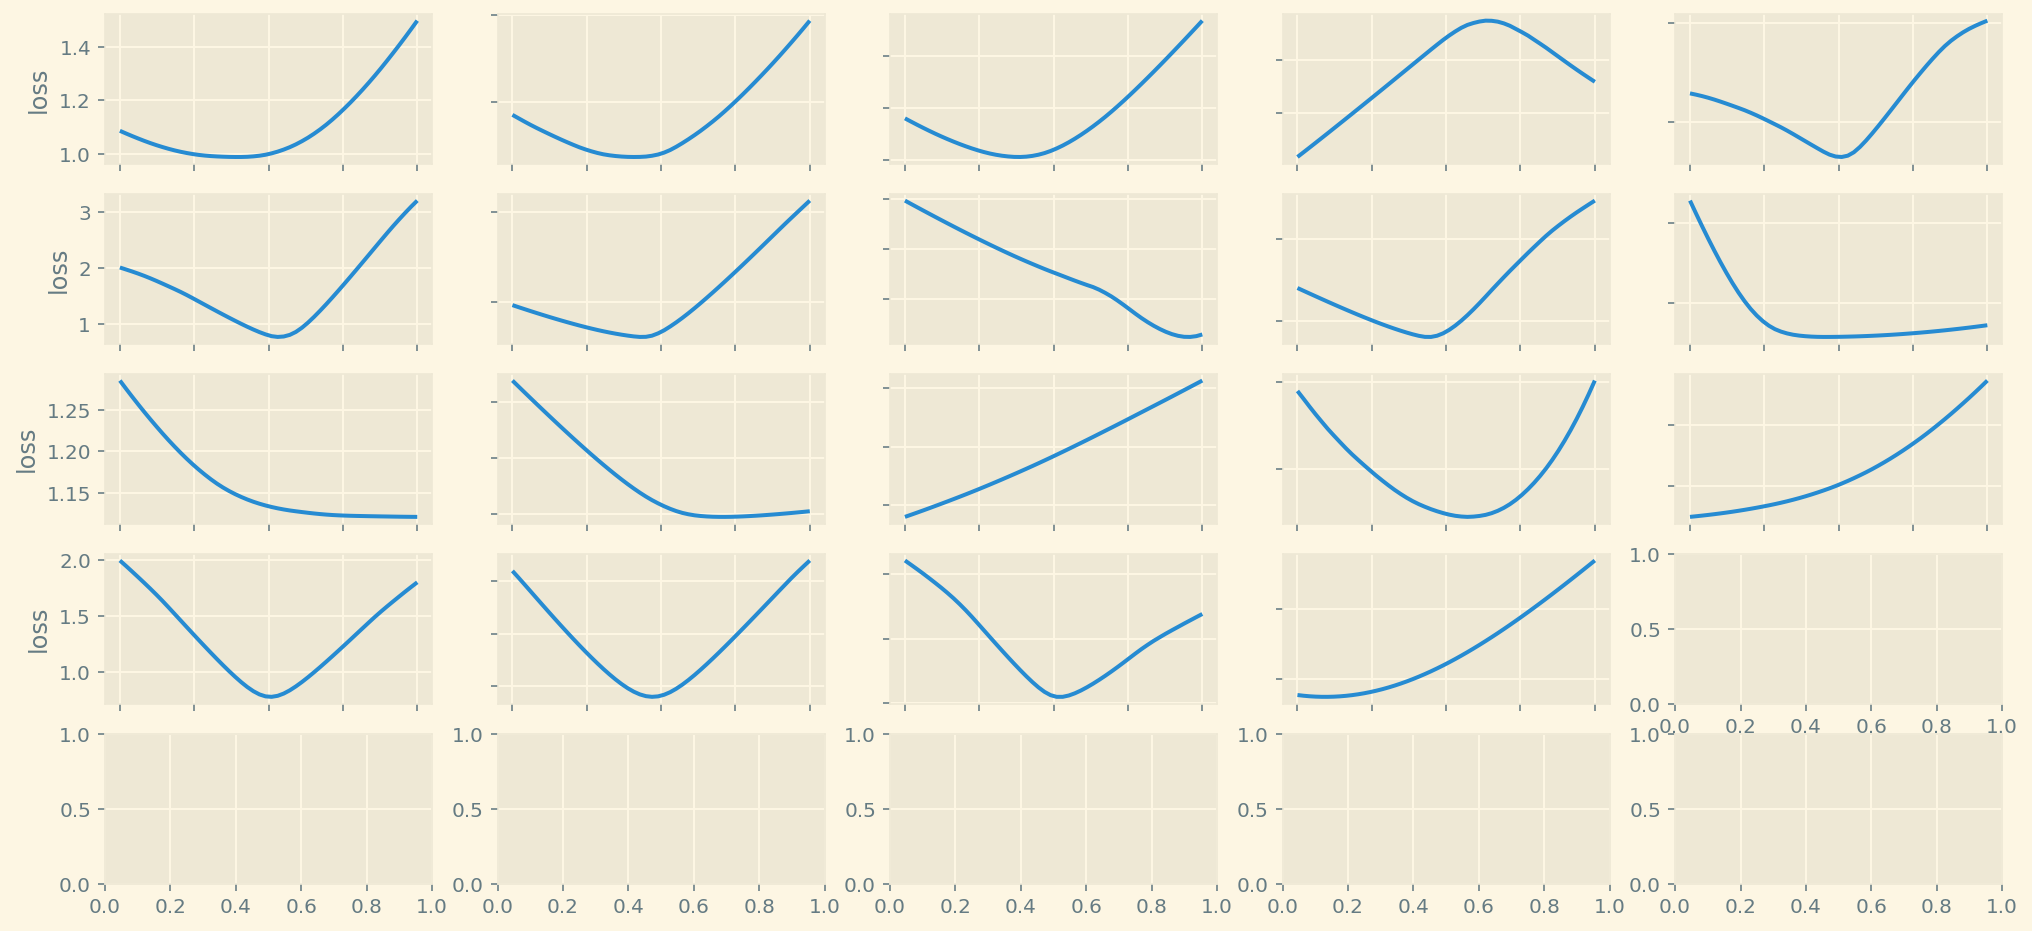

In [34]:
def get_loss_for_weight_value(model, index, x_train, y_train, value):
    weights = model.get_weights()

    if len(index) == 3:
        weights[index[0]][index[1]][index[2]] = value
    else:
        weights[index[0]][index[1]] = value

    model.set_weights(weights)
    predictions = model.predict(x_train)
    loss = tf.keras.losses.binary_crossentropy(y_train, predictions)
    return np.mean(loss)


def get_loss_range_for_weight(model, index):
    x, y = list(), list()

    for value in np.linspace(-2, 2, 50):
        loss = get_loss_for_weight_value(model, index, X_testing, y_testing, value)
        x.append(value)
        y.append(loss)

    min_index = y.index(min(y))
    return x, y, min_index


def plot_weight_2d(model, ax, index):
    model_copy = tf.keras.models.clone_model(model)
    x, y, min_index = get_loss_range_for_weight(model_copy, index)
    # print('The local minimum weight value is ' + str(x[min_index]) + ', and the loss is ' + str(y[min_index]))

    ax.plot(x, y)
    ax.set(xlabel='weight', ylabel='loss')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()


def plot_all_weights_2d(model):
    fig, axs = plt.subplots(5, 5)

    c = 0
    w = model.get_weights()
    for i in tqdm(range(len(w))):
        for j in range(len(w[i])):
            if isinstance(w[i][j], np.ndarray):
                for k in range(len(w[i][j])):
                    plot_weight_2d(model, axs[c // 5, c % 5], (i, j, k))
                    c += 1
            else:
                plot_weight_2d(model, axs[c // 5, c % 5], (i, j))
                c += 1

In [35]:
def get_loss_for_weights_values(model, index1, index2, x_train, y_train, n, m):
    weights = model.get_weights()

    if len(index1) == 3:
        weights[index1[0]][index1[1]][index1[2]] = n
    else:
        weights[index1[0]][index1[1]] = n

    if len(index2) == 3:
        weights[index2[0]][index2[1]][index2[2]] = m
    else:
        weights[index2[0]][index2[1]] = m

    model.set_weights(weights)
    predictions = model.predict(x_train)
    loss = tf.keras.losses.binary_crossentropy(y_train, predictions)
    return np.mean(loss)


def get_loss_range_for_weights(model, index1, index2, add_plain=True):
    x, y, z = list(), list(), list()
    x_p, y_p, z_p = list(), list(), list()

    for value_x in tqdm(np.linspace(-2, 2, 50)):
        for value_y in np.linspace(-2, 2, 50):
            loss = get_loss_for_weights_values(model, index1, index2, X_testing, y_testing, value_x, value_y)
            x.append(value_x)
            y.append(value_y)
            z.append(loss)

    if add_plain:
        for value in tqdm(np.linspace(-2, 2, 50)):
            loss = get_loss_for_weight_value(model, index1, X_testing, y_testing, value)
            x_p.append(value)
            y_p.append(0)
            z_p.append(loss)

    m = z.index(min(z))
    return (x, y, z), (x_p, y_p, z_p), m


def plot_weights_3d(model, ax, index1, index2, add_plain=True, view_cords=None):
    model_copy = tf.keras.models.clone_model(model)
    (x, y, z), (x_p, y_p, z_p), m = get_loss_range_for_weights(model_copy, index1, index2, add_plain=add_plain)

    # print('The local minimum weight values are ' + str(x[m]) + ' and ' + str(y[m]) + ', and the loss is ' + str(z[m]))

    ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none')
    ax.plot3D(x_p, y_p, z_p, 'red', linewidth=5)

    ax.set_xlabel('weight 1')
    ax.set_ylabel('weight 2')
    ax.set_zlabel('loss')

    if view_cords is not None:
        ax.view_init(view_cords[0], view_cords[1])

100%|██████████| 50/50 [00:02<00:00, 18.75it/s]


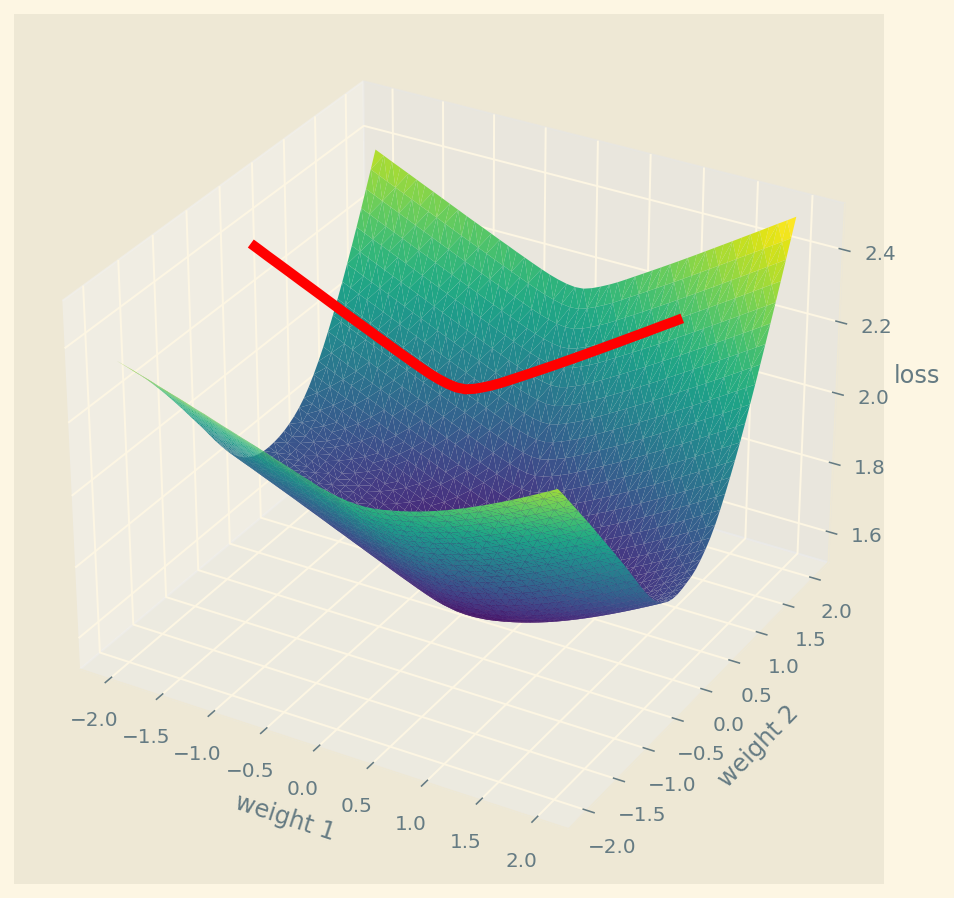

In [36]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plot_weights_3d(test_model, ax, (0, 0, 0), (0, 1, 1))

# Simulations for paper

In [ ]:
# Create a neural network
m1 = tf.keras.models.Sequential()
m1.add(tf.keras.layers.Dense(3, input_shape=(4,), activation="relu"))
m1.add(tf.keras.layers.Dense(1, activation="sigmoid"))

# Train neural network
m1.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

m1.fit(X_training, y_training, epochs=15)
#
# # Evaluate how well model performs
# model.evaluate(X_testing, y_testing, verbose=2)

In [ ]:
print(m1.get_weights())
